# Project 1 IN-STK5000/9000

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


In [2]:
# ser ut som dette gir gir sammme train test split første gang, så nye for hver kjøring
# kanskje det vi vil ...

# Akkurat det vi vil!
np.random.seed(2023)

# Read Data

In [3]:
diabetes = pd.read_csv('diabetes.csv')

binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                   'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                   'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']
diabetes.info()
print("Found:", len(cat_features+binary_features+num_features)+1) # +1 for Gender
print("In DS:", diabetes.shape[1]-1) # -1 for target


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 534 non-null    float64
 1   Gender              542 non-null    object 
 2   Race                537 non-null    object 
 3   Occupation          534 non-null    object 
 4   GP                  539 non-null    object 
 5   Height              538 non-null    float64
 6   Weight              541 non-null    float64
 7   Obesity             538 non-null    object 
 8   Temperature         546 non-null    float64
 9   Urination           532 non-null    float64
 10  TCep                546 non-null    object 
 11  Polydipsia          540 non-null    object 
 12  Sudden Weight Loss  530 non-null    object 
 13  Weakness            541 non-null    object 
 14  Polyphagia          544 non-null    object 
 15  Genital Thrush      538 non-null    object 
 16  Visual B

# First look at data

In [4]:
diabetes.sort_values(by=['Age'], ascending=False).head(10)

,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
449,377.0,Male,White,Consultant,Dr. Angharad Grainger,169.31,68.32,No,37.23,1.90,...,No,No,No,No,No,No,No,No,No,Positive
137,155.0,Male,White,Judge,Dr. Mayson Harris,167.12,65.05,No,36.99,1.58,...,No,Yes,No,No,No,No,No,No,No,Negative
20,90.0,Female,White,Retired,Dr. Andreea Gregory,165.87,67.48,No,36.86,NaN,...,No,Yes,Yes,Yes,No,No,No,Yes,Yes,Positive
416,90.0,Female,White,Retired,Dr. Mayson Harris,163.50,50.75,No,36.97,1.42,...,No,Yes,Yes,Yes,No,No,No,Yes,Yes,Positive
256,85.0,Male,White,Retired,Dr. Kason Lloyd,167.36,56.48,No,36.97,2.98,...,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Positive
59,85.0,Male,White,Retired,Dr. Arda O'Brien,185.81,72.88,No,36.70,2.53,...,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Positive
73,79.0,Male,White,Retired,Dr. Ingrid Mata,174.81,58.68,No,37.26,1.71,...,Yes,Yes,No,Yes,Yes,No,Yes,No,No,Positive
140,72.0,Male,White,Retired,Dr. Orla Arellano,186.05,67.45,No,36.86,2.85,...,Yes,No,Yes,Yes,No,Yes,Yes,NaN,Yes,Negative
440,72.0,Male,White,Retired,Dr. Kason Lloyd,168.27,70.57,No,37.43,2.95,...,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Negative
498,72.0,Male,White,Retired,Dr. Andreea Gregory,175.89,79.85,No,37.41,3.34,...,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Positive


In [5]:
print(diabetes.shape)
diabetes.describe(include='object') #include='object'

(546, 24)


,Gender,Race,Occupation,GP,Obesity,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
count,542,537,534,539,538,546,540,530,541,544,538,542,540,541,538,531,534,536,546
unique,2,3,12,20,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2
top,Male,White,Retired,Dr. Madison Guy,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Positive
freq,342,526,155,38,437,293,281,300,305,278,400,283,265,389,269,279,316,337,336


# Data clean up

## Data normalization
Data is from two sources, using different conventions. Need to be made into a consistent set.


In [6]:
# Converts meter to centimeter
condition = diabetes['Height'] < 100
diabetes.loc[condition, ['Height']] = diabetes.loc[condition, ['Height']].mul(100)

# Converts all binary features to lower case
for f in binary_features:
   diabetes[f] = diabetes[f].str.lower()

## Duplicates

we identify duplicates and delete them. We assume they are caused by an error in the data collection, and it's unlikely that there are two correct instances with the exact same values.  



### Find

In [7]:
dup = diabetes[diabetes.duplicated(keep=False)]
dup.sort_values(by=['Height'])

,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
321,59.0,Female,White,Retired,Dr. Lorelai York,148.02,40.56,no,37.30,1.33,...,no,no,no,no,no,no,no,no,no,Positive
83,59.0,Female,White,Retired,Dr. Lorelai York,148.02,40.56,no,37.30,1.33,...,no,no,no,no,no,no,no,no,no,Positive
337,45.0,Female,White,Journalist,Dr. Ingrid Mata,151.68,60.72,no,36.79,3.36,...,yes,no,yes,yes,yes,yes,yes,no,no,Positive
418,45.0,Female,White,Journalist,Dr. Ingrid Mata,151.68,60.72,no,36.79,3.36,...,yes,no,yes,yes,yes,yes,yes,no,no,Positive
144,47.0,Male,White,Economist,Dr. Khalid Sellers,154.01,61.12,no,37.16,3.24,...,no,no,no,no,no,no,no,yes,no,Positive
280,47.0,Male,White,Economist,Dr. Khalid Sellers,154.01,61.12,no,37.16,3.24,...,no,no,no,no,no,no,no,yes,no,Positive
333,30.0,Female,White,Lawyer,Dr. Albie Colon,155.74,55.04,no,36.91,3.18,...,yes,no,no,no,no,yes,no,no,no,Positive
17,30.0,Female,White,Lawyer,Dr. Albie Colon,155.74,55.04,no,36.91,3.18,...,yes,no,no,no,no,yes,no,no,no,Positive
134,28.0,Female,White,Architect,Dr. Lina Beech,156.71,66.40,NaN,36.77,1.73,...,yes,no,no,no,no,no,yes,no,no,Negative
126,28.0,Female,White,Architect,Dr. Lina Beech,156.71,66.40,NaN,36.77,1.73,...,yes,no,no,no,no,no,yes,no,no,Negative


### Remove

In [8]:
diabetes = diabetes.drop_duplicates(keep='first')
print(diabetes.shape)

(520, 24)


# Train - Test split
We split as early as possible to avoid cross contamination of information from the test set.

In [9]:
train_proportion = 0.8

train_idx = np.random.choice(diabetes.index, int(train_proportion*len(diabetes.index)), replace=False)

In [10]:
train = diabetes.loc[train_idx]
test = diabetes.drop(train_idx)
assert len(diabetes.index) == len(train.index) + len(test.index)

**From this point on, everything that is done on train data must be done on test data before predicting.**

# Outliers

For now have just removed the samples with outliers. Better approaches?

Maybe set them to NaN's and see if missing data processing can deal with them?

Maybe a hint in the assignment to do this since we are asked to handle outliers before missing data ...


## Detection

### Visual outlier detection

In [11]:
# Describe our cleaned data set
train.describe()

,Age,Height,Weight,Temperature,Urination
count,405.000000,408.000000,412.000000,416.000000,405.000000
mean,48.740741,168.667892,69.416748,37.002187,2.371160
std,20.623558,10.391145,15.600117,0.201253,1.138961
min,-22.000000,141.360000,40.350000,36.450000,0.830000
25%,39.000000,161.735000,57.747500,36.860000,1.620000
50%,48.000000,169.555000,66.980000,37.000000,2.580000
75%,57.000000,176.327500,79.830000,37.150000,2.890000
max,377.000000,193.950000,125.950000,37.440000,15.000000


We visually see from min/max values that height, weight and temperature are ok. We investigate age and urination further with some box plots

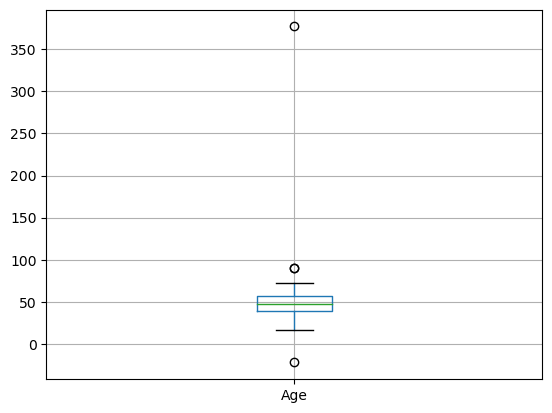

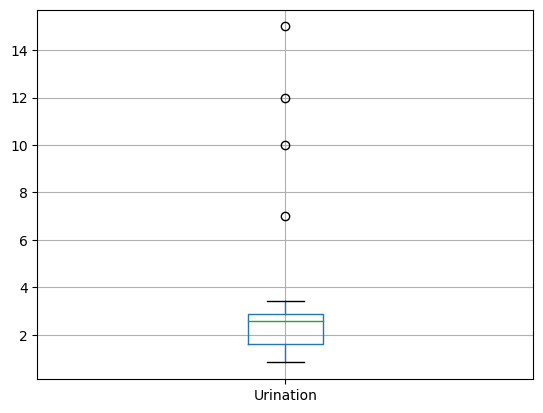

In [12]:
for f in ['Age', 'Urination']:
  bp = train.boxplot(f)
  bp.plot()
  plt.show()


### IQR Outlier detection

In [13]:
# Modified to return min, max values so it can be used on test set
def outliers_IQR(df, feature):
  try:

    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1

    # lower bounds
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return lower, upper
    #outliers = df[(df[feature] < lower) | (df[feature] > upper)]
    #return outliers
  except Exception as e:
    print("invalid feature")



### Z Score Outlier detection

In [14]:
def outliers_z_score(df, feature, no_z=3):
  lower = df[feature].mean()-no_z*df[feature].std()
  upper = df[feature].mean()+no_z*df[feature].std()
  return lower, upper

### Min / Max Rule

In [15]:
# Generalize min max rule used for age
# Returns DF of outliers, maybe use index instead?
def outliers_min_max(df, feature, min=None, max=None):
  try:
    cond_min = df[feature] < min if min != None else False
    cond_max = df[feature] > max if max != None else False
    return df[cond_min | cond_max ]
  except Exception as e:
    print("invalid feature")

### Age

Det kan se ut som at det er noen rare instanser på alder

In [16]:
# Check for negative, too high or NaN values
invalid_val_age = train[(train['Age'] < 0) | (train['Age'] > 120) ]
# Andreas: removed cond | (diabetes['Age'].isnull()), missing data handled under

# Get the indices of the invalid instances
invalid_indices = invalid_val_age.index

# Drop the invalid instances from original dataframe
#diabetes = diabetes.drop(invalid_indices)

In [17]:
# check for outliers in 'Age' coloumn with IQR

age_min, age_max = outliers_IQR(train, 'Age')
age_min2, age_max2 = outliers_z_score(train, 'Age')

print("IQR:", age_min, age_max)
print("Z-score:", age_min2, age_max2)
outliers_min_max(train, 'Age', age_min, age_max)

IQR: 12.0 84.0
Z-score: -13.129932425306258 110.61141390678773


,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
416,90.0,Female,White,Retired,Dr. Mayson Harris,163.50,50.75,no,36.97,1.42,...,no,yes,yes,yes,no,no,no,yes,yes,Positive
399,-22.0,Male,White,Dentist,Dr. Ingrid Mata,174.25,71.10,no,36.96,2.63,...,no,yes,no,no,yes,no,yes,no,yes,Positive
449,377.0,Male,White,Consultant,Dr. Angharad Grainger,169.31,68.32,no,37.23,1.90,...,no,no,no,no,no,no,no,no,no,Positive
20,90.0,Female,White,Retired,Dr. Andreea Gregory,165.87,67.48,no,36.86,NaN,...,no,yes,yes,yes,no,no,no,yes,yes,Positive


Vi ser her 7 instanser av outliers fra alderskolonna. Tre av dem er invalid verdier ( negativ alder eller for høy alder). Min intuisjon er å fjerne disse instansene.
Det er også noen instanser som er utenfor normalfordelingen
-Helene

### Urination

For this one there might be information in "Polydipsia", might be an idea to replace with nan, instead of removing, if we get a good method for estimating nan's.

for outliers urination, sett de om har polydipsia = no lik snittet for urination gitt polydipsia = no og tilsvarende for yes

Also, in general, we might end up not using certain features at all, in which case there is no point in dropping samples for missing values/outliers of data we end up not using.

## Handle

In [18]:
# test. to be removed soon.

min_urin, max_urin = outliers_IQR(train, 'Urination')

outliers_urin = outliers_min_max(train, 'Urination', min_urin, max_urin)
train.loc[outliers_urin.index, 'Urination'] = np.NaN
train.loc[outliers_urin.index]

,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
193,35.0,Female,White,Consultant,Dr. Albie Colon,158.65,55.24,no,36.99,NaN,...,yes,no,no,yes,no,no,yes,no,no,Positive
138,39.0,Male,White,Lawyer,Dr. Ingrid Mata,174.51,83.65,no,37.19,NaN,...,no,yes,no,yes,yes,no,no,no,yes,Positive
497,68.0,Female,White,Retired,Dr. Madison Guy,173.62,71.84,no,36.94,NaN,...,yes,no,yes,yes,no,yes,yes,no,no,Positive
68,51.0,Female,White,NaN,Dr. Korey Clay,158.46,69.57,no,36.89,NaN,...,no,yes,no,yes,no,yes,no,no,yes,Negative


In [19]:
# Function that can be run on both training set and test set
# TODO: Fix hypothetcial outliers in new data ...
def handle_outliers(df):
  # Age
  outliers_age = outliers_min_max(df, 'Age', min=0, max=120)

  #df = df.drop(outliers_age.index)
  # Change from drop to set Nan
  df.loc[outliers_age.index, 'Age'] = np.NaN

  #print(outliers_age)

  # Urination
  # must identify from training set
  min_urin, max_urin = outliers_IQR(train, 'Urination')
  # can not be negative, doesnt really matter because we have no data where this is the case,
  # can happen in "production"?
  min_urin = max(0, min_urin)
  outliers_urin = outliers_min_max(df, 'Urination', min_urin, max_urin)

  # Remove by IQR
  # Change to set missing
  #df = df.drop(outliers_urin.index)
  df.loc[outliers_urin.index, 'Urination'] = np.NaN

  #print(outliers_urin[['Urination','Polydipsia']])
  return df

print("Before removal of outliers:", train.shape)
train = handle_outliers(train)
test = handle_outliers(test)
print("After removal of outliers:", train.shape)

# How does it look now? All min max values sensible ...
train.describe()

Before removal of outliers: (416, 24)
After removal of outliers: (416, 24)


,Age,Height,Weight,Temperature,Urination
count,403.000000,408.000000,412.000000,416.000000,401.000000
mean,48.101737,168.667892,69.416748,37.002187,2.285087
std,12.105550,10.391145,15.600117,0.201253,0.687902
min,16.000000,141.360000,40.350000,36.450000,0.830000
25%,39.000000,161.735000,57.747500,36.860000,1.610000
50%,48.000000,169.555000,66.980000,37.000000,2.580000
75%,56.500000,176.327500,79.830000,37.150000,2.890000
max,90.000000,193.950000,125.950000,37.440000,3.430000




```
# Dette er formatert som kode
```

# Missing data

## Find

NB! if this is used to answer questions about the whole data set:
- use whole data set, do not do anything with outliers ...

In [20]:
def check_missing_data(df):
  print(df.isna().sum().sort_values(ascending=False))
  print(df.isna().mean().sort_values(ascending=False))
  print("Total number of missing data:", df.isna().sum().sum())
  print("Percentage of missing data:", df.isna().mean().mean())
  print("Samples with at least one missing value:", len(df[df.isnull().any(axis=1)]))
  print("Percentage samples with at least one missing value:", len(df[df.isnull().any(axis=1)])/len(df))

check_missing_data(train)

Urination             15
Age                   13
Partial Paresis       13
Sudden Weight Loss    12
Occupation            11
Muscle Stiffness       9
Race                   8
Alopecia               8
Height                 8
Genital Thrush         7
Polydipsia             6
GP                     5
Delayed Healing        5
Weight                 4
Obesity                4
Weakness               4
Irritability           4
Gender                 3
Visual Blurring        3
Itching                3
Polyphagia             2
TCep                   0
Temperature            0
Diabetes               0
dtype: int64
Urination             0.036058
Age                   0.031250
Partial Paresis       0.031250
Sudden Weight Loss    0.028846
Occupation            0.026442
Muscle Stiffness      0.021635
Race                  0.019231
Alopecia              0.019231
Height                0.019231
Genital Thrush        0.016827
Polydipsia            0.014423
GP                    0.012019
Delayed Healing

In [21]:
# missing more than 2
for i in train[train.isna().sum(axis=1) > 2].index:
  print(train.loc[i,])

Age                              34.0
Gender                         Female
Race                            White
Occupation                    Dentist
GP                    Dr. Albie Colon
Height                         156.04
Weight                          47.94
Obesity                            no
Temperature                      37.1
Urination                        2.79
TCep                               no
Polydipsia                        NaN
Sudden Weight Loss                NaN
Weakness                          yes
Polyphagia                         no
Genital Thrush                     no
Visual Blurring                    no
Itching                            no
Irritability                      yes
Delayed Healing                    no
Partial Paresis                   NaN
Muscle Stiffness                  yes
Alopecia                           no
Diabetes                     Positive
Name: 187, dtype: object
Age                                 37.0
Gender                

Almost 30% of the samples in the training data are missing at least one value. A max of 20 rows are missing two or more. Can delete those that have more than one missing and try to fix the rest?

## Handle

Can column be derived from other data? If so we might not need both anyway

**Binary:**  
Remove sample?  
Set to false?  
Set to random (50-50)?  
Set to majority?  
Set to mean (probability)?

**Categoric:**  
Category for unknown data?

**Numeric:**  
Remove sample?  
Set to mean?  
Set to random?

If any method uses data training set can not know we should consider using training data only. Eg Training set does not know mean of whole data set...



### Derived from other features

In [22]:
def BMI(weight, height):
  return weight/(height**2/(100*100))

idx = train[train['Obesity'].isna()].index

missing_obesity = train.loc[idx]
missing_obesity = missing_obesity[['Height', 'Weight', 'Obesity']]
missing_obesity['BMI'] = BMI(missing_obesity['Weight'], missing_obesity['Height'])
missing_obesity


,Height,Weight,Obesity,BMI
217,169.52,60.77,NaN,21.146931
205,147.89,48.46,NaN,22.156736
332,144.17,53.96,NaN,25.961043
98,184.55,86.07,NaN,25.271074


In [23]:
def fix_obesity(df):
  idx = df[df['Obesity'].isna()].index
  # This is ugly ...
  idx2 = df.loc[idx,].loc[BMI(df.loc[idx,]["Weight"], df.loc[idx,]["Height"]) <= 30].index
  # maybe not set obesity to 1 for high BMI, to avoid "Body Builder" problem
  # It is possible to have high BMI without Obesity, the case of low BMI and Obesity harder to imagine
  idx3 = df.loc[idx,].loc[BMI(df.loc[idx,]["Weight"], df.loc[idx,]["Height"]) > 30].index
  #print(idx2)
  #print(idx3)
  df.loc[idx2,'Obesity'] = 'no'
  df.loc[idx3,'Obesity'] = 'yes'
  #df.loc[idx,]
  return df

train = fix_obesity(train)
test = fix_obesity(test)

### Set missing binaries false

In [24]:
train[binary_features] = train[binary_features].fillna('no')
train.head(30)
check_missing_data(train)


test[binary_features] = test[binary_features].fillna('no')
check_missing_data(test)

Urination             15
Age                   13
Occupation            11
Race                   8
Height                 8
GP                     5
Weight                 4
Gender                 3
Visual Blurring        0
Alopecia               0
Muscle Stiffness       0
Partial Paresis        0
Delayed Healing        0
Irritability           0
Itching                0
Sudden Weight Loss     0
Genital Thrush         0
Polyphagia             0
Weakness               0
Polydipsia             0
TCep                   0
Temperature            0
Obesity                0
Diabetes               0
dtype: int64
Urination             0.036058
Age                   0.031250
Occupation            0.026442
Race                  0.019231
Height                0.019231
GP                    0.012019
Weight                0.009615
Gender                0.007212
Visual Blurring       0.000000
Alopecia              0.000000
Muscle Stiffness      0.000000
Partial Paresis       0.000000
Delayed Healing

## Missing categorial data

I suggest treating missing categorical data (not binary) as a separate class. This allows us to identify possible bias in the censoring process.

# Encoding

Should we encode binary features/target? Ie to 0, 1.

Also where in the "Pipeline", maybe right after Normalization?

Categories need to be "one hot encoded".

In [25]:
# NB! Very important to Normalize data before running this, if not there will be a bunch of NaN's!
# Also, if run twice things get messed up. Need to fix that ...
def encode(df):
  # Target
  if ('Positive' in df['Diabetes'].unique()):
    df['Diabetes'] = df['Diabetes'].map({'Positive': 1, 'Negative': 0})

  # Gender
  if ('Female' in df['Gender'].unique()):
    df['Gender'] = df['Gender'].map({'Female': 1, 'Male': 0})

  # Binaries
  for f in binary_features:
    if ('yes' in df[f].unique()):
      df[f] = df[f].map(dict(yes=1, no=0))

  # One hot encode categoricals

  one_hot_df = pd.get_dummies(df[cat_features], drop_first=True, dummy_na=True)

  return df, one_hot_df

train, train_one_hot = encode(train)
test, test_one_hot = encode(test)



# Don't join in one_hot_df just yet, will probably cause some problems ....
#train = train.join(train_one_hot)
# And after doing that drop the cats ..
#train.drop(cat_features, inplace=True, axis=1)
#train

train.head(5)
#train_one_hot.head(10)

,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
24,64.0,0.0,White,Retired,Dr. Khalid Sellers,185.30,82.17,0,37.24,2.39,...,1,0,1,1,1,1,0,1,1,0
308,43.0,0.0,White,Manager,Dr. Andreea Gregory,176.93,65.45,0,37.07,1.84,...,0,0,0,0,0,0,0,0,1,0
177,48.0,1.0,White,Engineer,Dr. Dominic Farmer,164.62,69.06,0,37.16,2.88,...,1,0,1,1,1,1,1,1,0,1
184,48.0,0.0,White,Dentist,Dr. Alice Watson,NaN,73.59,0,36.91,2.65,...,0,1,1,1,0,0,0,0,0,1
4,30.0,1.0,White,Judge,Dr. Lorelai York,155.23,48.16,0,36.92,3.13,...,1,0,0,0,0,1,0,0,0,1


In [26]:
train_one_hot.head(5)

,Race_White,Race_nan,Occupation_Consultant,Occupation_Dentist,Occupation_Economist,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Judge,Occupation_Lawyer,...,GP_Dr. Kason Lloyd,GP_Dr. Khalid Sellers,GP_Dr. Korey Clay,GP_Dr. Lina Beech,GP_Dr. Lorelai York,GP_Dr. Madison Guy,GP_Dr. Mayson Harris,GP_Dr. Nial Higgs,GP_Dr. Orla Arellano,GP_nan
24,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
308,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
184,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


# Correlations

In [27]:
corr = train.corr(numeric_only=True)
#corr['Diabetes']
#sns.heatmap(corr)

# look at the smallest and largest in absolute value
cmap = 'coolwarm' # Added colour map as a variable for consistent plot style
corrs = corr.stack().loc[lambda x : (x < 1)].abs().sort_values()
print("Smallest:")
print(corrs[:20])
print("-------------------------------")
print("Largest:")
print(corrs[-20:])

corr.style.background_gradient(cmap=cmap).set_precision(2)

Smallest:
Weight           Visual Blurring    0.003166
Visual Blurring  Weight             0.003166
Alopecia         Temperature        0.005215
Temperature      Alopecia           0.005215
Obesity          Alopecia           0.005361
Alopecia         Obesity            0.005361
Weight           TCep               0.006422
TCep             Weight             0.006422
Itching          Diabetes           0.006660
Diabetes         Itching            0.006660
Weakness         Genital Thrush     0.012381
Genital Thrush   Weakness           0.012381
Temperature      Genital Thrush     0.012458
Genital Thrush   Temperature        0.012458
Partial Paresis  Temperature        0.013676
Temperature      Partial Paresis    0.013676
Delayed Healing  Diabetes           0.014446
Diabetes         Delayed Healing    0.014446
Partial Paresis  Obesity            0.014523
Obesity          Partial Paresis    0.014523
dtype: float64
-------------------------------
Largest:
Itching          Delayed Healing  

/var/folders/ps/_kmvj3_s5w5109d0211tgc9r0000gn/T/ipykernel_43471/3250011536.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap=cmap).set_precision(2)


,Age,Gender,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
Age,1.00,-0.05,0.05,0.13,0.15,0.02,0.19,-0.10,0.12,0.04,0.18,0.28,0.06,0.40,0.28,0.24,0.25,0.23,0.31,0.34,0.12
Gender,-0.05,1.00,-0.73,-0.37,0.02,0.04,0.29,-0.15,0.32,0.29,0.12,0.22,-0.21,0.19,0.09,0.03,0.09,0.34,0.05,-0.33,0.42
Height,0.05,-0.73,1.00,0.54,-0.03,-0.03,-0.26,0.05,-0.27,-0.22,-0.14,-0.16,0.18,-0.16,-0.04,-0.03,-0.10,-0.25,-0.07,0.22,-0.31
Weight,0.13,-0.37,0.54,1.00,0.57,0.03,-0.02,-0.01,-0.04,-0.03,-0.04,-0.06,0.18,0.00,0.02,0.08,-0.07,-0.14,0.07,0.15,-0.11
Obesity,0.15,0.02,-0.03,0.57,1.00,0.07,0.14,-0.04,0.05,0.19,0.04,0.03,0.11,0.10,-0.02,0.15,-0.09,-0.01,0.18,0.01,0.08
Temperature,0.02,0.04,-0.03,0.03,0.07,1.00,0.07,-0.05,0.07,0.06,0.03,0.06,0.01,0.02,-0.03,0.05,0.05,0.01,0.02,0.01,0.08
Urination,0.19,0.29,-0.26,-0.02,0.14,0.07,1.00,-0.29,0.54,0.39,0.24,0.37,0.05,0.21,0.07,0.22,0.09,0.42,0.13,-0.16,0.63
TCep,-0.10,-0.15,0.05,-0.01,-0.04,-0.05,-0.29,1.00,-0.30,-0.17,-0.15,-0.15,-0.03,-0.13,-0.08,-0.16,-0.02,-0.22,-0.06,0.07,-0.48
Polydipsia,0.12,0.32,-0.27,-0.04,0.05,0.07,0.54,-0.30,1.00,0.37,0.33,0.31,0.03,0.32,0.13,0.19,0.11,0.43,0.18,-0.32,0.65
Sudden Weight Loss,0.04,0.29,-0.22,-0.03,0.19,0.06,0.39,-0.17,0.37,1.00,0.21,0.19,0.02,0.04,-0.02,0.14,0.04,0.27,0.08,-0.21,0.40


## Categorical correlation

I implememented the Chi-square test for dataframes.

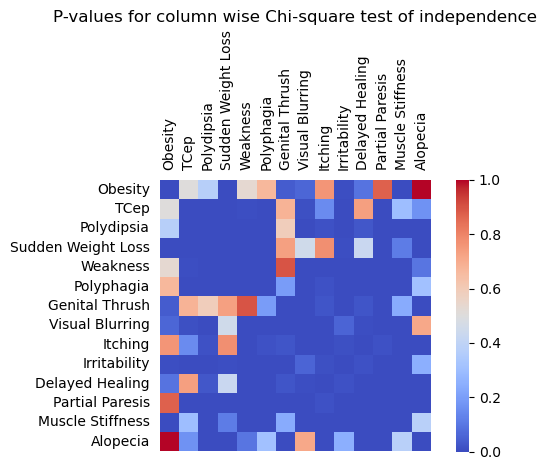

In [28]:
from helpers import plot_chi_square_p_values
plot_chi_square_p_values(train[binary_features], kwargs={'cmap' : cmap})


In [29]:
pd.crosstab(train['Alopecia'], train['Obesity'])

Obesity,0,1
Alopecia,,
0,228,41
1,124,23


## Correlations with Target

In [30]:
corr_matrix = train.corr()['Diabetes']
print(corr_matrix.sort_values(ascending=False))

# Gender er faktisk viktig, et kjapt Google søk antyder at kvinner kan ha høyere risiko for Diabetes 2
# intressant å se lav korrelasjon med Obesity, men dette bekreftes av en Cross tab
print('-----------------------------------')
print(pd.crosstab(train['Obesity'], train['Diabetes'], rownames=['Obesity'], colnames=['Diabetes']))

Diabetes              1.000000
Polydipsia            0.652991
Urination             0.627790
Partial Paresis       0.444927
Gender                0.415757
Sudden Weight Loss    0.397720
Polyphagia            0.336067
Irritability          0.318016
Visual Blurring       0.248880
Weakness              0.238048
Muscle Stiffness      0.133545
Age                   0.118509
Genital Thrush        0.108632
Temperature           0.079919
Obesity               0.078543
Delayed Healing       0.014446
Itching               0.006660
Weight               -0.109783
Alopecia             -0.245597
Height               -0.312890
TCep                 -0.476154
Name: Diabetes, dtype: float64
-----------------------------------
Diabetes    0    1
Obesity           
0         136  216
1          18   46


/var/folders/ps/_kmvj3_s5w5109d0211tgc9r0000gn/T/ipykernel_43471/1070232132.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()['Diabetes']


In [31]:
pd.crosstab(train['TCep'], train['Obesity'])
# Tcep: folk som er opptatt av utseende, har sjeldnere Diabetes

Obesity,0,1
TCep,,
0,201,40
1,151,24


In [32]:
def chi_square_target(df: pd.DataFrame):
    n = len(df.columns)
    colnames = df.columns

    res = np.zeros(shape=(n, 1)) # to store results
    for i in range(n):


      # Crosstab constructs the Contingency table for column i against j
      test_result = chi2_contingency(pd.crosstab(df[colnames[i]],
                                                  df['Diabetes']).to_numpy())
      #print(test_result.pvalue)
      res[0,1] = test_result.pvalue
    return res

result = pd.DataFrame(train.columns.drop('Diabetes'), columns=['Var'])

#chi2_contingency(pd.crosstab(result['Var'], train['Diabetes']))
#result



# Data Exploration

In [33]:
# There are some interesting things to see in the categoricals ...
# Only one Black in entire data set ...
# This looks very much like a rich person data set ...
for c in cat_features:
  print(train.groupby(c, dropna=False).size())

#print(train['GP'].unique())

Race
Asian      6
White    402
NaN        8
dtype: int64
Occupation
Architect        27
Consultant       30
Dentist          33
Economist        30
Engineer         23
Entrepreneur     23
Journalist       22
Judge            36
Lawyer           28
Manager          34
Retired         118
Student           1
NaN              11
dtype: int64
GP
Dr. Albie Colon          26
Dr. Alice Watson         19
Dr. Andreea Gregory      25
Dr. Angharad Grainger    19
Dr. Arda O'Brien         20
Dr. Cristiano Ayala      13
Dr. Dominic Farmer       18
Dr. Ingrid Mata          19
Dr. Jamil Walters        16
Dr. Joshua Riley         26
Dr. Kameron Lancaster    27
Dr. Kason Lloyd          18
Dr. Khalid Sellers       21
Dr. Korey Clay           25
Dr. Lina Beech           18
Dr. Lorelai York         20
Dr. Madison Guy          28
Dr. Mayson Harris        19
Dr. Nial Higgs           18
Dr. Orla Arellano        16
NaN                       5
dtype: int64


In [34]:
train['BMI'] = BMI(train['Weight'], train['Height'])
train.plot.scatter('BMI', 'Obesity')
#train.drop('BMI', axis=1)

test['BMI'] = BMI(test['Weight'], test['Height'])


In [35]:
train.plot.scatter('Urination', 'Polydipsia')
print(train.groupby('Polydipsia')['Urination'].mean())

Polydipsia
0    1.945662
1    2.693516
Name: Urination, dtype: float64


In [36]:
train['Age'].plot.hist(bins=20)

<Axes: xlabel='Urination', ylabel='Frequency'>

In [37]:
# After encoding, pair-plotting diabetes is messed up, because it tries to make 23*23 plots?
# need to drop the binaries from DF plotted.
train_plot = train.drop(binary_features + ['Gender'], axis=1)

#diabetes_plot = train.drop('Gender', axis=1)
g = sns.pairplot(train_plot, hue='Diabetes')

In [38]:
g = sns.pairplot(train_plot, kind='reg')

In [39]:
for f in binary_features:
  cross_tab = pd.crosstab(diabetes[f], diabetes['Diabetes'], rownames=[f], colnames=['Diabetes'])
  print(cross_tab)
  print('-----------------------')

Diabetes  Negative  Positive
Obesity                     
no             171       264
yes             25        53
-----------------------
Diabetes  Negative  Positive
TCep                        
no              54       243
yes            146        77
-----------------------
Diabetes    Negative  Positive
Polydipsia                    
no               190        94
yes                8       222
-----------------------
Diabetes            Negative  Positive
Sudden Weight Loss                    
no                       169       127
yes                       29       181
-----------------------
Diabetes  Negative  Positive
Weakness                    
no             110       100
yes             87       218
-----------------------
Diabetes    Negative  Positive
Polyphagia                    
no               151       131
yes               48       188
-----------------------
Diabetes        Negative  Positive
Genital Thrush                    
no                   163       236

# Feature Selection

In [40]:

#selected_features = ['Urination', 'Age'] + binary_features
selected_features = num_features + binary_features + ['Gender']
print(selected_features)
print(len(selected_features))
train2 = train[selected_features+['Diabetes']]
print(train2.shape)
train2 = train2.dropna(axis=0)
print(train2.shape)

# This is so stupid ... Never mind, Decision tree does not seem to care if X is series or DF ...
# Naive Bayes does, I think ...
#if len(selected_features) == 1:
#  X_train = train2[[selected_features[0]]]
#else:
X_train = train2[selected_features]

y_train = train2['Diabetes']

['Age', 'Height', 'Weight', 'Temperature', 'Urination', 'Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness', 'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'Gender']
20
(416, 21)
(375, 21)


In [41]:
len(selected_features)
print

<function print>

Age : 12.70108337245969
Height : 24.134900143905124
Weight : 14.562892051899446
Temperature : 0.0016560407357273984
Urination : 31.334759071000548
Obesity : 2.234716960505236
TCep : 47.7198929833786
Polydipsia : 86.03833923401288
Sudden Weight Loss : 35.19618240359613
Weakness : 7.444893083991979
Polyphagia : 22.06568753668725
Genital Thrush : 3.197449552954978
Visual Blurring : 12.044491698628768
Itching : 0.039019631752225406
Irritability : 28.264921960736494
Delayed Healing : 0.03146393296984696
Partial Paresis : 40.352720955610536
Muscle Stiffness : 2.9970430435312787
Alopecia : 17.16207802988379
Gender : 46.505092635761784


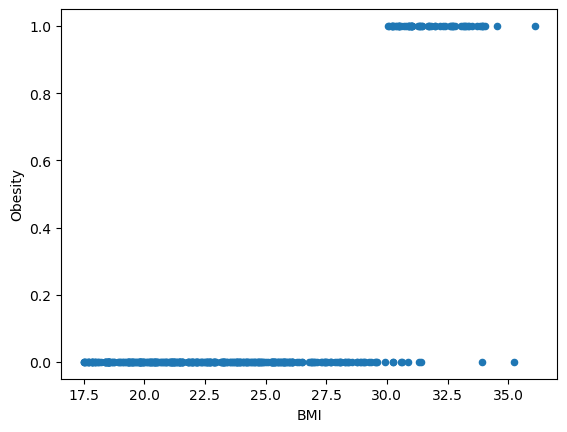

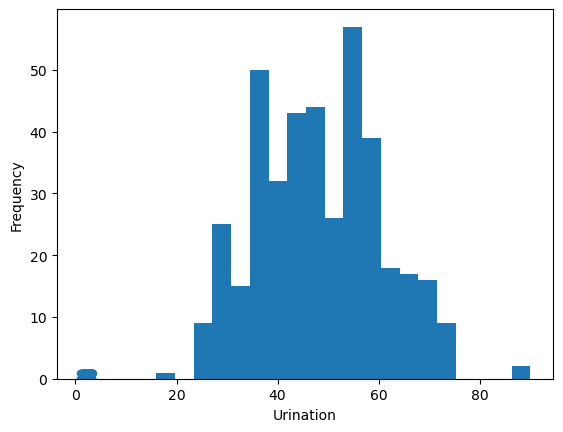

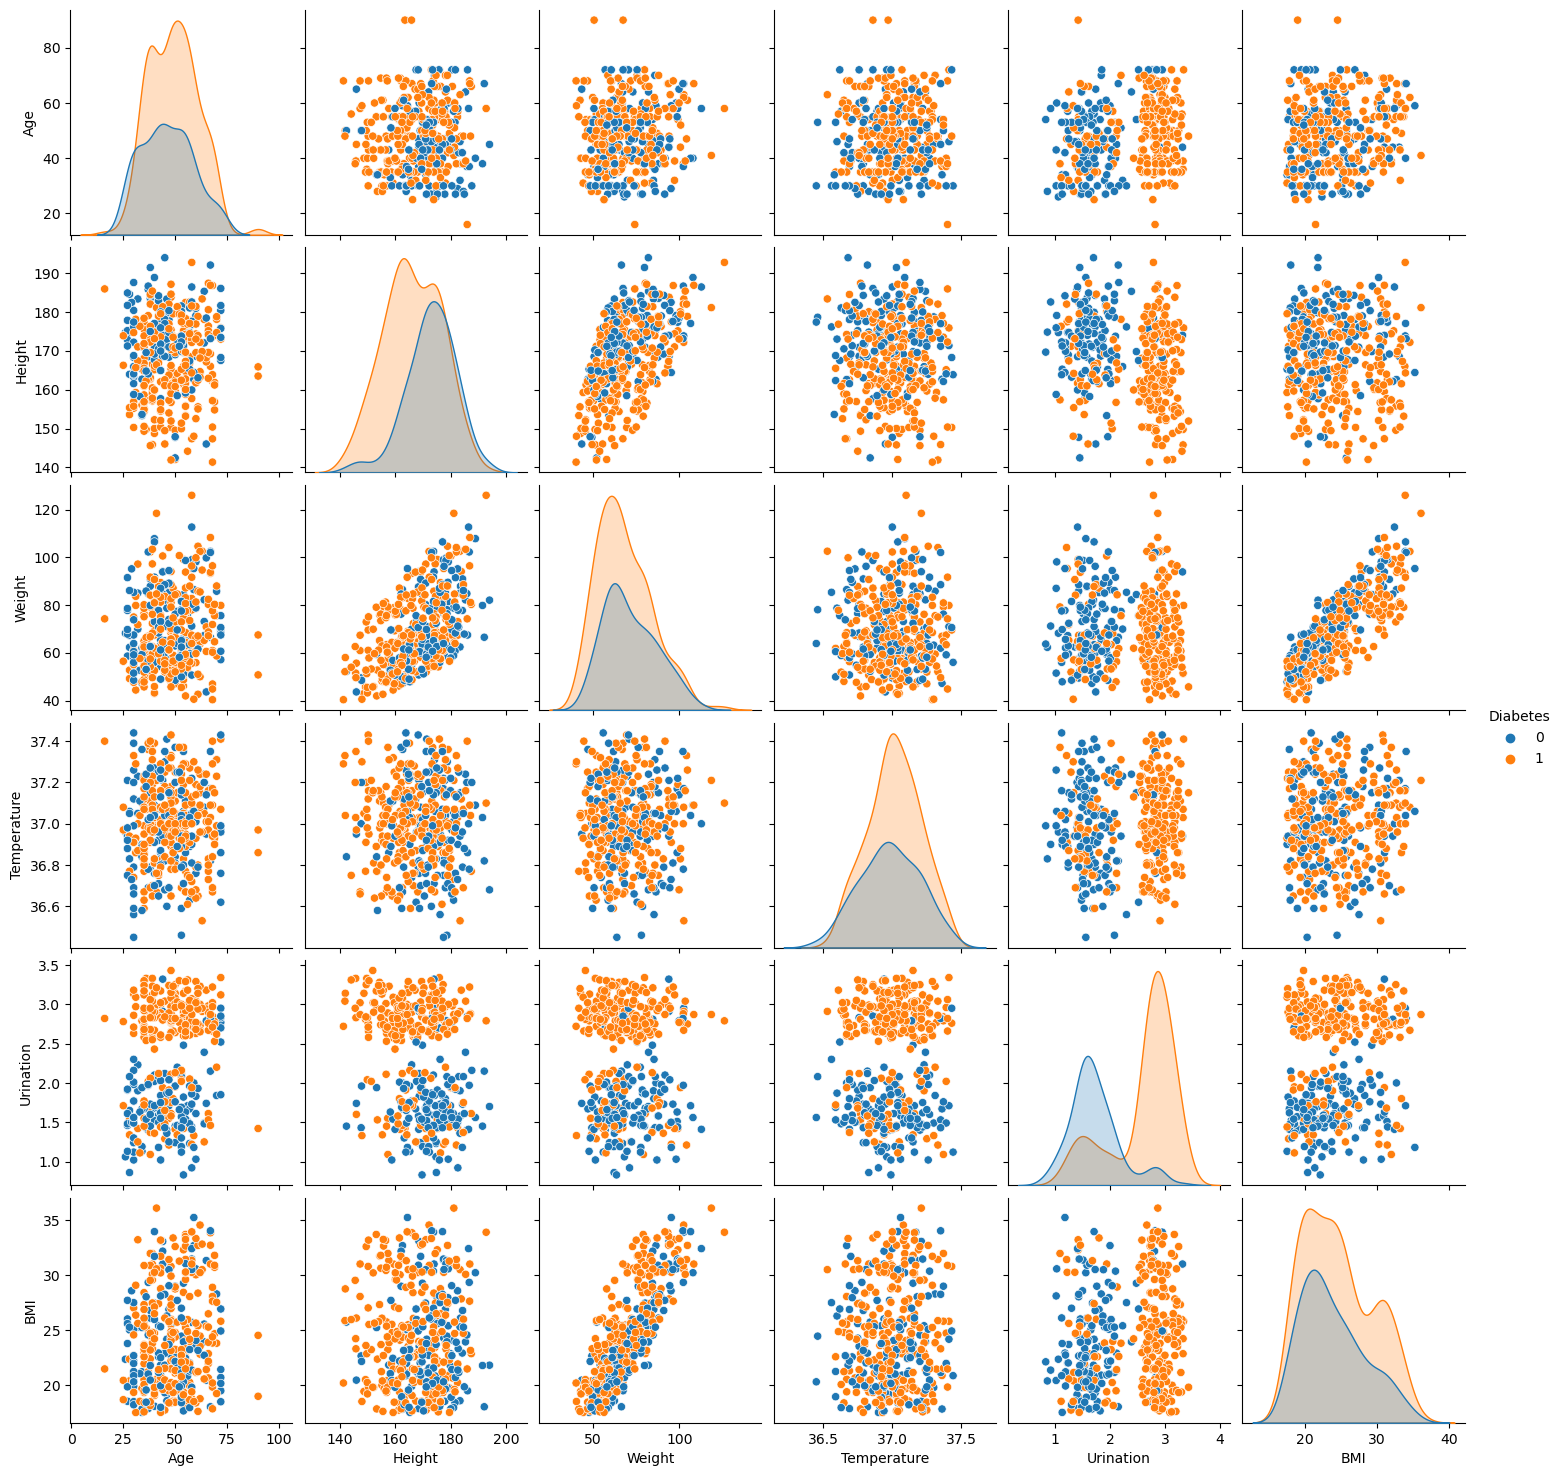

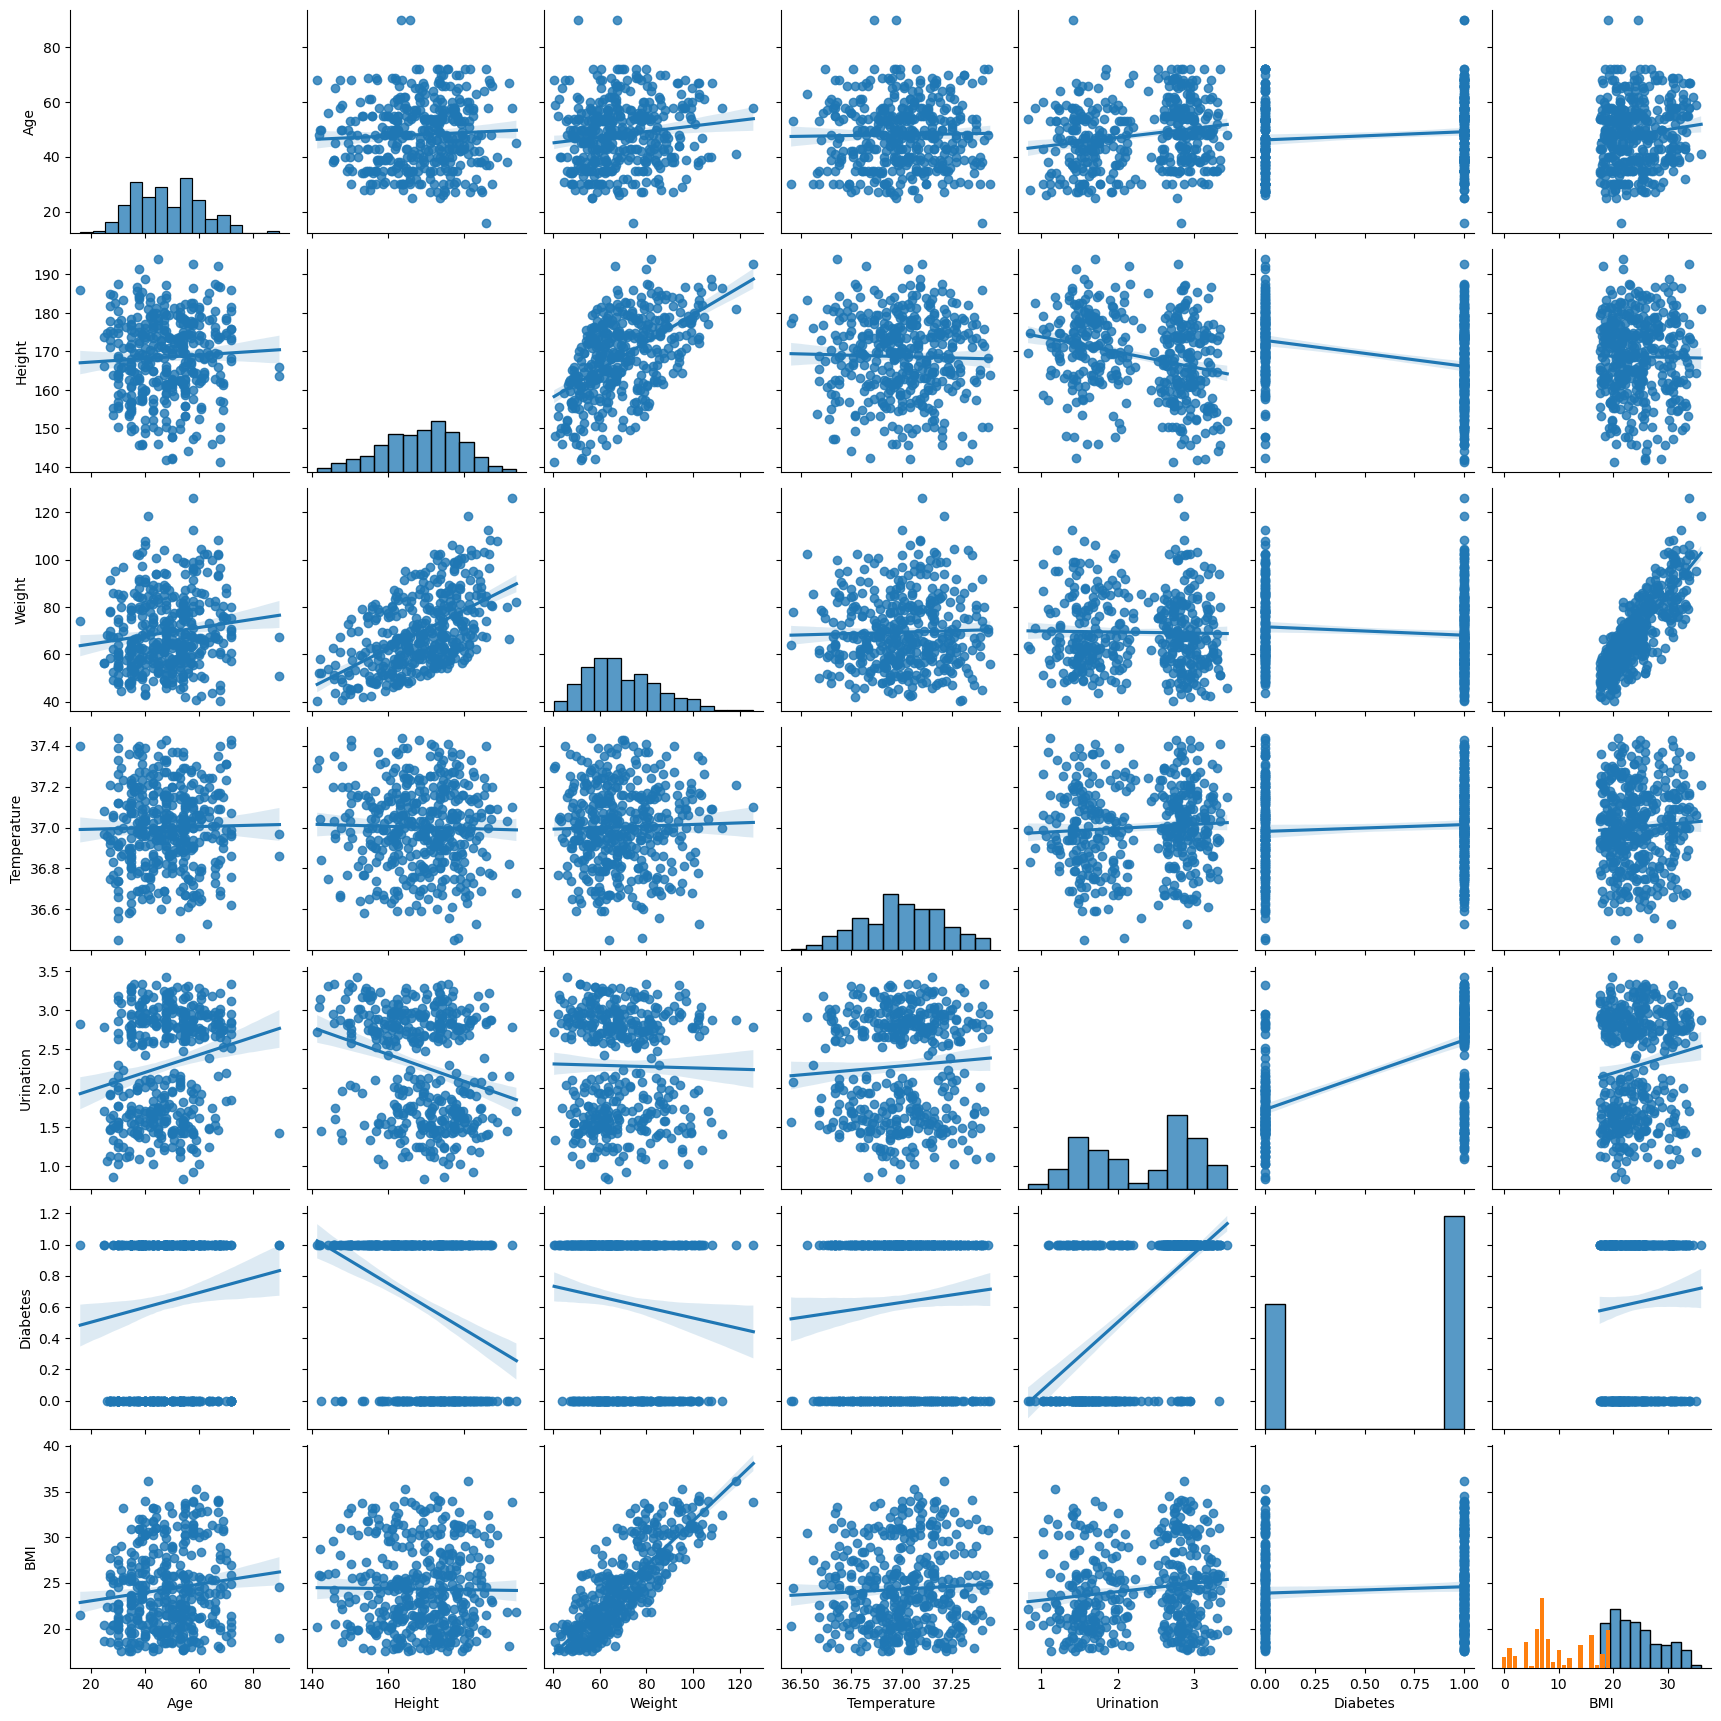

,Age,Height,Weight,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Irritability,Partial Paresis,Alopecia,Gender
24,64.0,185.30,82.17,2.39,1,0,0,1,1,0,1,1,0,1,0.0
308,43.0,176.93,65.45,1.84,0,0,0,0,0,0,0,0,0,1,0.0
177,48.0,164.62,69.06,2.88,0,1,1,1,1,0,1,1,1,0,1.0
4,30.0,155.23,48.16,3.13,0,0,1,1,1,0,0,0,0,0,1.0
224,54.0,174.36,78.72,1.58,0,0,0,1,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,72.0,173.45,60.64,1.85,1,0,0,0,1,0,1,0,0,1,0.0
427,16.0,185.92,74.22,2.82,0,0,1,0,1,0,0,0,0,0,0.0
370,40.0,173.11,90.69,1.36,1,1,0,1,0,0,0,0,0,1,0.0
55,52.0,171.17,58.13,1.66,0,0,0,1,1,0,0,0,0,1,0.0


In [42]:
from sklearn.feature_selection import SelectKBest, chi2
skb =  SelectKBest(chi2, k=15)
X_new = skb.fit_transform(X_train, y_train)

cols_idxs = skb.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]



# what are scores for the features
for i in range(len(skb.scores_)):
 print(X_train.columns[i], ":", skb.scores_[i])
# plot the scores
plt.bar([i for i in range(len(skb.scores_))], skb.scores_)
plt.show()
features_df_new

# Classification

## Train a Learner

In [43]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depths = list(range(1, 20))

scores = {}

"""
By weighing misslcassification more severly, we can minimze type II error,
which is desirable in the public health scenario. However, even with
a very skewed weighing (1-100), we still get missclassification,
indicatting that there are 'outliers' in the test set.

Further investigation revealed that they typically where quite old or quite young,
with a typical amount of urination.
"""
weight = {0: 1,
          1:100}

use_weights = False

for d in depths:
    clf_cv = tree.DecisionTreeClassifier(max_depth=d, class_weight=weight if use_weights else None)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Decision tree with depth={d}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())

clf = tree.DecisionTreeClassifier(max_depth=7, class_weight=weight if use_weights else None)
clf = clf.fit(X_train, y_train)

Decision tree with depth=1. cv score: 0.7973333333333333
Decision tree with depth=2. cv score: 0.8693333333333333
Decision tree with depth=3. cv score: 0.8746666666666666
Decision tree with depth=4. cv score: 0.9039999999999999
Decision tree with depth=5. cv score: 0.9119999999999999
Decision tree with depth=6. cv score: 0.9146666666666666
Decision tree with depth=7. cv score: 0.8986666666666666
Decision tree with depth=8. cv score: 0.9066666666666666
Decision tree with depth=9. cv score: 0.9066666666666666
Decision tree with depth=10. cv score: 0.9066666666666666
Decision tree with depth=11. cv score: 0.9066666666666666
Decision tree with depth=12. cv score: 0.8986666666666666
Decision tree with depth=13. cv score: 0.9013333333333333
Decision tree with depth=14. cv score: 0.9120000000000001
Decision tree with depth=15. cv score: 0.9039999999999999
Decision tree with depth=16. cv score: 0.9013333333333333
Decision tree with depth=17. cv score: 0.8959999999999999
Decision tree with dept

In [44]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=selected_features,
                      class_names='Diabetes',
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
# Make Pdf
#graph.render("Diabetes")
graph

InvalidParameterError: The 'class_names' parameter of export_graphviz must be an array-like, an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int' or None. Got 'Diabetes' instead.

In [ ]:
# Training accuracy
from sklearn import metrics
y_train_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_train_pred)

0.9973333333333333

In [ ]:
# Test set
test2 = test[selected_features+['Diabetes']]
print(test2.shape)
test2 = test2.dropna(axis=0)
print(test2.shape)
#print(train.shape)
X_test = test2[selected_features]
y_test = test2['Diabetes']
y_test

(104, 21)
(100, 21)


6      0
15     1
19     0
25     1
28     1
      ..
530    1
538    1
539    1
540    1
545    0
Name: Diabetes, Length: 100, dtype: int64

In [ ]:
y_test_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.9

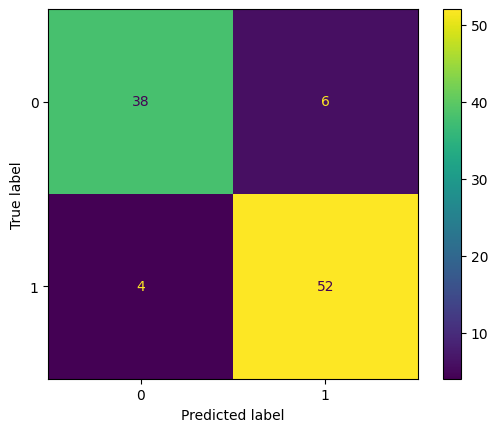

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()

In [ ]:
X_test[ y_test > y_test_pred]

,Age,Height,Weight,Temperature,Urination,Obesity,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Gender
59,85.0,185.81,72.88,36.70,2.53,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0.0
256,85.0,167.36,56.48,36.97,2.98,0,0,1,1,1,1,1,1,1,0,1,1,1,0,0.0
475,45.0,186.76,61.68,37.22,1.43,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0.0
492,60.0,162.27,85.15,36.82,2.79,1,0,1,1,1,1,0,1,1,0,1,1,1,0,1.0


In [ ]:
X_test_plot = X_test.copy()
X_test_plot['error'] = y_test > y_test_pred

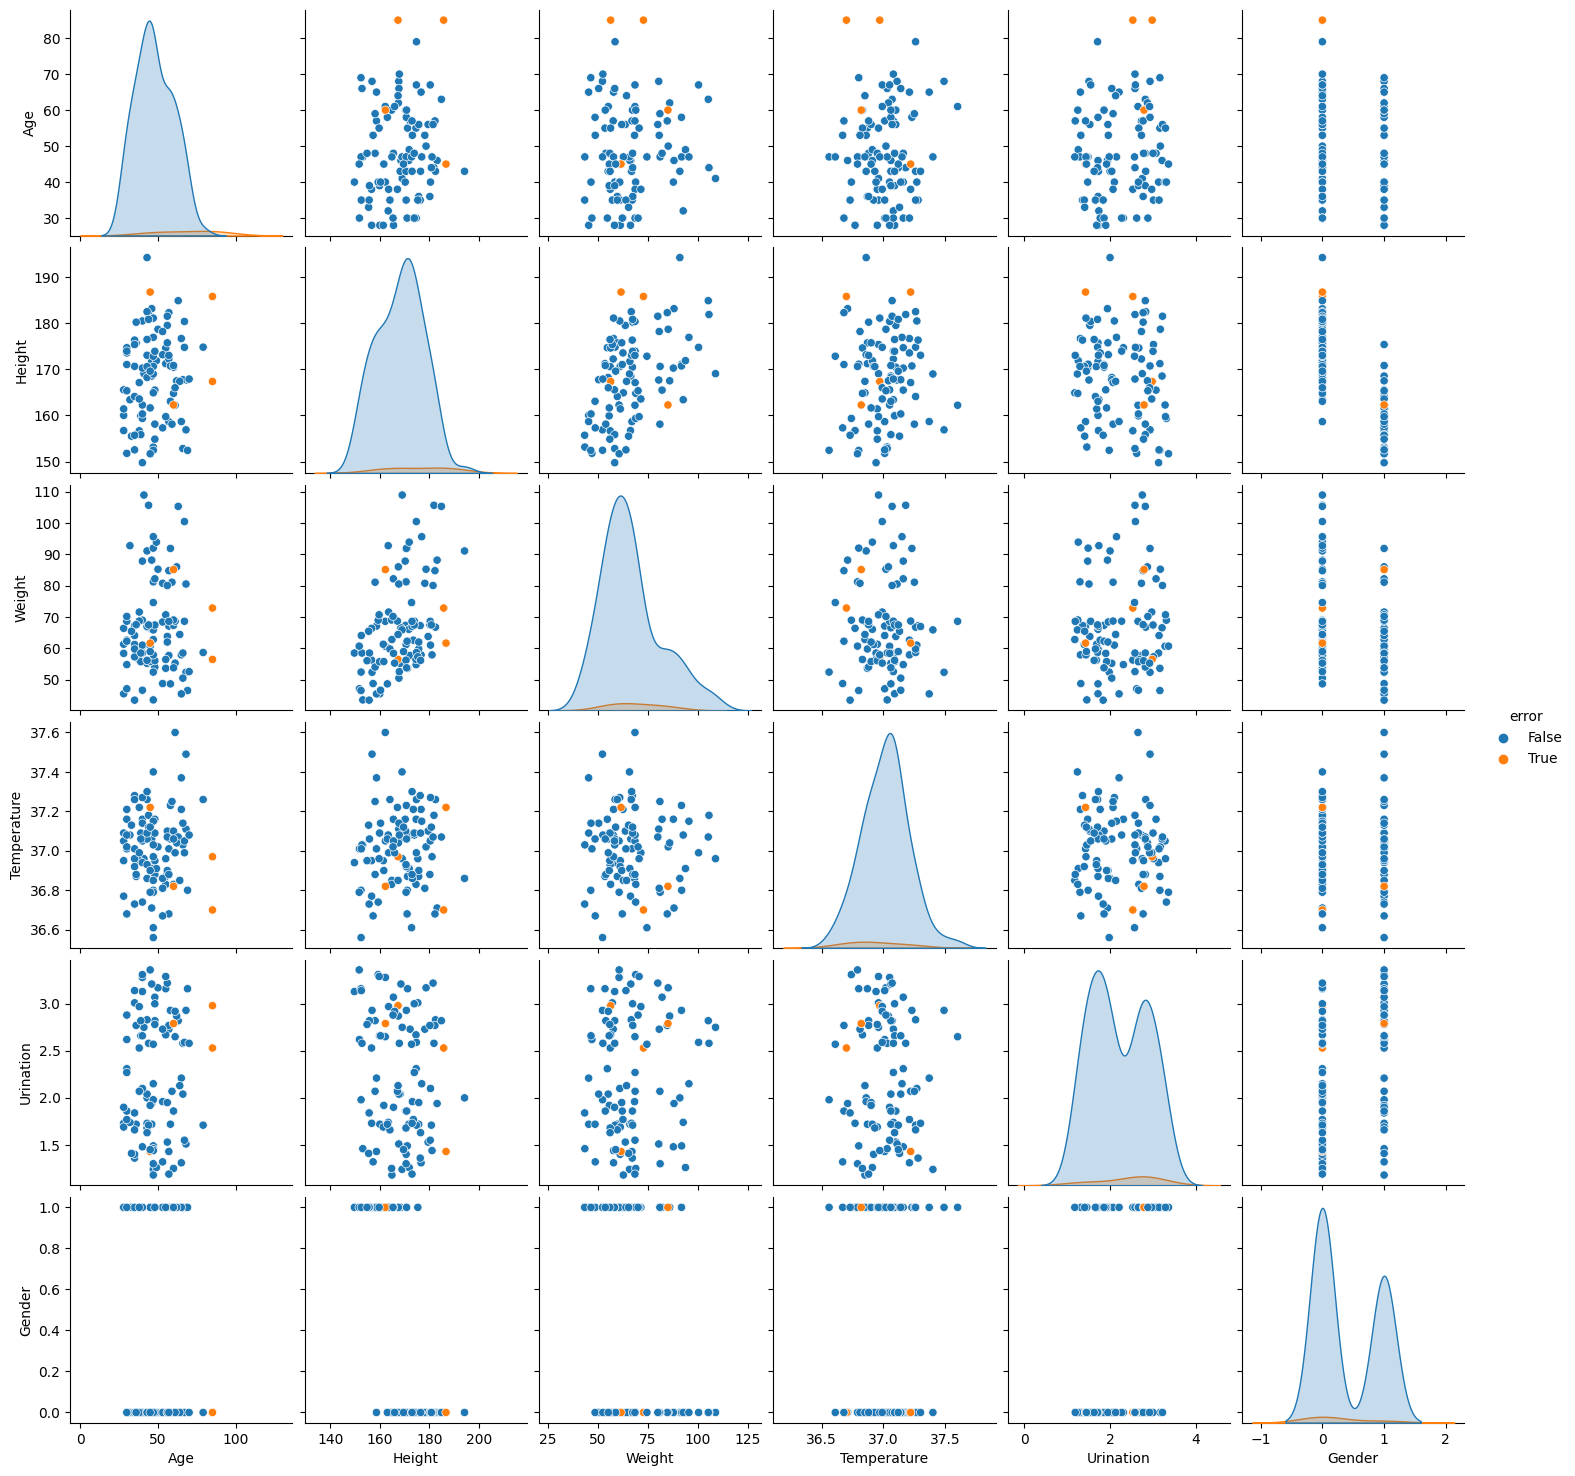

In [ ]:
g = sns.pairplot(X_test_plot.drop(binary_features, axis=1), hue='error')

Logistic regression with C = 10.00. cv score: 0.9226666666666666
Logistic regression with C = 7.85. cv score: 0.9226666666666666
Logistic regression with C = 6.16. cv score: 0.9226666666666666
Logistic regression with C = 4.83. cv score: 0.9306666666666666
Logistic regression with C = 3.79. cv score: 0.9306666666666666
Logistic regression with C = 2.98. cv score: 0.9306666666666666
Logistic regression with C = 2.34. cv score: 0.9306666666666666
Logistic regression with C = 1.83. cv score: 0.9279999999999999
Logistic regression with C = 1.44. cv score: 0.9333333333333333
Logistic regression with C = 1.13. cv score: 0.9333333333333333
Logistic regression with C = 0.89. cv score: 0.9306666666666666
Logistic regression with C = 0.70. cv score: 0.9306666666666666
Logistic regression with C = 0.55. cv score: 0.9306666666666666
Logistic regression with C = 0.43. cv score: 0.9333333333333333
Logistic regression with C = 0.34. cv score: 0.9306666666666666
Logistic regression with C = 0.26. cv s

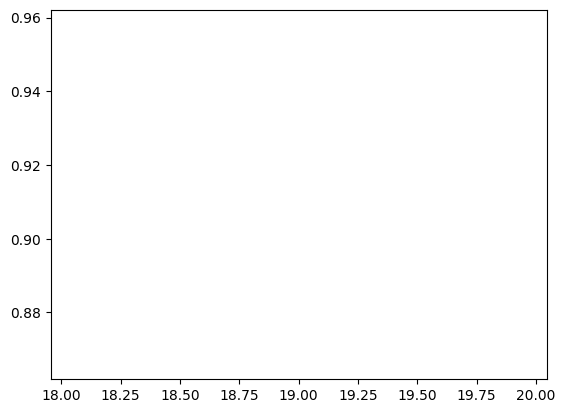

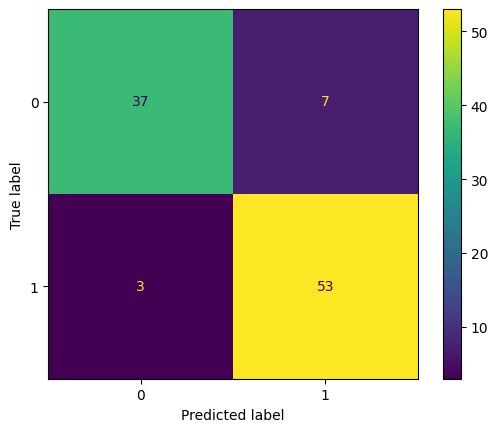

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1000)

cs = 1/np.geomspace(0.1, 10, 20)

scores = {}


for c in cs:
    clf_cv = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Logistic regression with C = {c:.2f}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())



clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

# Accuracy
print(metrics.accuracy_score(y_test, y_test_pred))
print(clf.coef_)

# Confusion Matrix
confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()
